In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score, classification_report, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
import statsmodels.api as sm

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.y.value_counts(normalize=True)
# Imabalanced

no     0.887346
yes    0.112654
Name: y, dtype: float64

In [5]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
# Assume FN more expensive. Want to maximize recall. Minimize Type II error.
# Essence is to rank the prospects better.

In [7]:
df.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

In [8]:
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
drop_feats = ['duration', 'month', 'day_of_week', 'pdays']


In [9]:
# Encode label
df.y = np.where(df.y=='yes', 1, 0)

# New features from EDA
df.age_opportunity_flag = np.where((df.age>=60) & (df.age<=90), 1, 0)
df.middle_of_week = np.where((df.day_of_week.isin(['tue','wed','thu'])), 1, 0)
# df = df.select_dtypes(exclude="object")
df.drop(columns = drop_feats, inplace=True)

# One hot encoding for categorical features
enc = OneHotEncoder()
df_cat = enc.fit_transform(df[cat_vars]).toarray()
df.drop(columns=cat_vars, inplace=True)
df = pd.concat([df, pd.DataFrame(df_cat, columns = enc.get_feature_names(cat_vars))], axis=1)

/home/mathedwi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/home/mathedwi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [10]:
df.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [11]:
# Train, valiedation and test split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'y'], df['y'], test_size=0.2, random_state=0, stratify = df['y'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify = y_train)

In [12]:
# Standardizing the data
STD = StandardScaler()
X_train = pd.DataFrame(STD.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(STD.transform(X_val), columns = X_val.columns)
X_test = pd.DataFrame(STD.transform(X_test), columns = X_test.columns)

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
X_train.corr()[(X_train.corr() > 0.8) | (X_train.corr() < -0.8)]
# Exclude highly correlated euribor3m, nr.employed, housing_unknown, poutcome_nonexistent, housing_no, loan_no, contact_telephone

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.879651,NaN
emp.var.rate,NaN,NaN,NaN,1.000000,NaN,NaN,0.972554,0.907648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cons.price.idx,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cons.conf.idx,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
euribor3m,NaN,NaN,NaN,0.972554,NaN,NaN,1.000000,0.945129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nr.employed,NaN,NaN,NaN,0.907648,NaN,NaN,0.945129,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_admin.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_blue-collar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
corr_feats = ['euribor3m', 'nr.employed', 'housing_unknown', 'poutcome_nonexistent', 'housing_no', 'loan_no', 'contact_telephone']
X_train.drop(columns = corr_feats, inplace=True)
X_val.drop(columns = corr_feats, inplace=True)
X_test.drop(columns = corr_feats, inplace=True)

In [16]:
X_train.corrwith(y_train)

age                             -0.001369
campaign                         0.003121
previous                         0.004657
emp.var.rate                    -0.007331
cons.price.idx                  -0.014939
cons.conf.idx                   -0.004260
job_admin.                       0.001315
job_blue-collar                  0.002964
job_entrepreneur                 0.006381
job_housemaid                    0.000574
job_management                  -0.008892
job_retired                     -0.007064
job_self-employed                0.008706
job_services                     0.001121
job_student                     -0.010933
job_technician                   0.002638
job_unemployed                   0.000221
job_unknown                     -0.008105
marital_divorced                 0.010848
marital_married                 -0.010231
marital_single                   0.004791
marital_unknown                 -0.011240
education_basic.4y              -0.009837
education_basic.6y              -0

In [19]:
c = [1000,100,10,1,0.1,0.01,0.001]

auc_lis = []

for i in c:
    clf = LogisticRegression(penalty='l1',C=i, solver='liblinear')
    clf.fit(X_train,y_train)
    y_pred_prob = clf.predict_proba(X_val)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
    auc_precision_recall = auc(recall, precision)
    auc_lis.append(auc_precision_recall)

In [20]:
# Area under PR curve
auc_lis
# Mostly consistent

[0.45377994815226036,
 0.45377869182827735,
 0.45376421812614626,
 0.45394100522599634,
 0.45455669584044,
 0.4524710373085904,
 0.4205971570144949]

In [38]:
# With object columns removed from dataframe
# print(classification_report(y_val, y_pred))
#               precision    recall  f1-score   support

#            0       0.93      0.97      0.95      9144
#            1       0.66      0.42      0.51      1153

#     accuracy                           0.91     10297
#    macro avg       0.80      0.70      0.73     10297
# weighted avg       0.90      0.91      0.90     10297



              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9144
           1       0.66      0.42      0.51      1153

    accuracy                           0.91     10297
   macro avg       0.80      0.70      0.73     10297
weighted avg       0.90      0.91      0.90     10297



In [164]:
# Recall went down from 42% to 20% after adding categorical features

# print(classification_report(y_val, y_pred))
#               precision    recall  f1-score   support

#            0       0.91      0.99      0.95      7319
#            1       0.66      0.20      0.30       919

#     accuracy                           0.90      8238
#    macro avg       0.79      0.59      0.62      8238
# weighted avg       0.88      0.90      0.87      8238



              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7319
           1       0.66      0.20      0.30       919

    accuracy                           0.90      8238
   macro avg       0.79      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



In [208]:
# L1 Regularization with categorical features added
# print(classification_report(y_test, y_pred))
#               precision    recall  f1-score   support

#            0       0.91      0.99      0.95      7319
#            1       0.66      0.21      0.32       919

#     accuracy                           0.90      8238
#    macro avg       0.78      0.60      0.63      8238
# weighted avg       0.88      0.90      0.88      8238



              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7319
           1       0.66      0.21      0.32       919

    accuracy                           0.90      8238
   macro avg       0.78      0.60      0.63      8238
weighted avg       0.88      0.90      0.88      8238



In [49]:
model.intercept_

array([0.0031327])

In [46]:
model.coef_[0]

array([ 0.00237582,  0.00443202, -0.03311529, -0.00166041, -0.02378342,
       -0.25401796,  0.29320887,  0.04209604, -0.26977468, -0.00528334])

In [209]:
# Beta coefficients for L1
for i, j in zip(df.columns, model.coef_[0]):
    print(i, j)
    
# age 0.0017990908319138507
# campaign -0.03625802406422031
# pdays -0.001497454597989076
# previous -0.11351336241897099
# emp.var.rate -0.3523084248441477
# cons.price.idx 0.4362834471859875
# cons.conf.idx 0.020452746774324574
# euribor3m 0.1334164739311534
# nr.employed -0.007929944830687373
# y 0.021035111789672323
# job_admin. -0.21897572778881694
# job_blue-collar 0.0
# job_entrepreneur 0.03454729261402668
# job_housemaid -0.028763570836379555
# job_management 0.21820320293273085
# job_retired -0.10318501016575424
# job_self-employed -0.22488029219936712
# job_services 0.21707249762884745
# job_student -0.07194240494806414
# job_technician 0.05113756956946072
# job_unemployed 0.0
# job_unknown -0.09135617548294954
# marital_divorced -0.0665407452565541
# marital_married 0.0
# marital_single 0.3582389810721507
# marital_unknown -0.06909219838555092
# education_basic.4y 0.0
# education_basic.6y -0.09909689265809252
# education_basic.9y -0.021180262202907862
# education_high.school 0.306871446838105
# education_illiterate -0.0936942240007974
# education_professional.course 0.03831622054744933
# education_university.degree 0.04458250548645366
# education_unknown 0.0
# default_no -0.2644818779080933
# default_unknown 0.0
# default_yes 0.0
# housing_no -0.09241939290494737
# housing_unknown 0.010681956836891751
# housing_yes 0.015159636205365465
# loan_no -0.05502268011700366
# loan_unknown 0.0
# loan_yes 0.0
# contact_cellular -0.6791426362072706
# contact_telephone -0.40963588789540495
# poutcome_failure 0.020736172572287576
# poutcome_nonexistent 0.0


age 0.0017990908319138507
campaign -0.03625802406422031
pdays -0.001497454597989076
previous -0.11351336241897099
emp.var.rate -0.3523084248441477
cons.price.idx 0.4362834471859875
cons.conf.idx 0.020452746774324574
euribor3m 0.1334164739311534
nr.employed -0.007929944830687373
y 0.021035111789672323
job_admin. -0.21897572778881694
job_blue-collar 0.0
job_entrepreneur 0.03454729261402668
job_housemaid -0.028763570836379555
job_management 0.21820320293273085
job_retired -0.10318501016575424
job_self-employed -0.22488029219936712
job_services 0.21707249762884745
job_student -0.07194240494806414
job_technician 0.05113756956946072
job_unemployed 0.0
job_unknown -0.09135617548294954
marital_divorced -0.0665407452565541
marital_married 0.0
marital_single 0.3582389810721507
marital_unknown -0.06909219838555092
education_basic.4y 0.0
education_basic.6y -0.09909689265809252
education_basic.9y -0.021180262202907862
education_high.school 0.306871446838105
education_illiterate -0.0936942240007974


# Making an explainable L1 Regularized model

In [26]:
# Statsmodel L1 Log Regression
sm_model = sm.Logit(list(y_train), X_train).fit_regularized(method='l1', L1_wt=1)
sm_model.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6424106909613754
            Iterations: 48
            Function evaluations: 48
            Gradient evaluations: 48


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                26360
Model:                          Logit   Df Residuals:                    26321
Method:                           MLE   Df Model:                           38
Date:                Sun, 18 Jul 2021   Pseudo R-squ.:                 -0.8247
Time:                        01:40:39   Log-Likelihood:                -16934.
converged:                       True   LL-Null:                       -9280.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0118      0.017      0.703      0.482      -0.021       0.045
campaign                         -0.0211      0.013     -1.621      0.105      -0.047       0.004
previous                          0.2637      0.055      4.809      0.000       0.156       0.371
emp.var.rate                     -0.6831      0.028    -24.510      0.000      -0.738      -0.628
cons.price.idx                    0.5174      0.030     17.097      0.000       0.458       0.577
cons.conf.idx                     0.2049      0.016     12.759      0.000       0.173       0.236
job_admin.                        0.0106   5.14e+05   2.06e-08      1.000   -1.01e+06    1.01e+06
job_blue-collar                  -0.0239   4.95e+05  -4.83e-08      1.000    -9.7e+05     9.7e+05
job_entrepreneur                  0.0005   2.16e+05   2.26e-09      1.000   -4.24e+05    4.24e+05
job_housemaid                    -0.0033    1.9e+05  -1.72e-08      1.000   -3.72e+05    3.72e+05
job_management                   -0.0010   3.06e+05  -3.31e-09      1.000   -6.01e+05    6.01e+05
job_retired                       0.0438   2.36e+05   1.85e-07      1.000   -4.63e+05    4.63e+05
job_self-employed                 0.0011   2.11e+05   5.27e-09      1.000   -4.14e+05    4.14e+05
job_services                     -0.0085   3.47e+05  -2.45e-08      1.000   -6.79e+05    6.79e+05
job_student                       0.0534   1.71e+05   3.13e-07      1.000   -3.34e+05    3.34e+05
job_technician                    0.0045   4.34e+05   1.03e-08      1.000   -8.51e+05    8.51e+05
job_unemployed                   -0.0069    1.8e+05  -3.86e-08      1.000   -3.52e+05    3.52e+05
job_unknown                      -0.0146   1.06e+05  -1.38e-07      1.000   -2.08e+05    2.08e+05
marital_divorced                  0.0004   2.81e+05   1.57e-09      1.000    -5.5e+05     5.5e+05
marital_married                  -0.0005   4.33e+05  -1.25e-09      1.000   -8.49e+05    8.49e+05
marital_single                    0.0154   3.97e+05   3.89e-08      1.000   -7.78e+05    7.78e+05
marital_unknown                  -0.0019   3.98e+04  -4.74e-08      1.000   -7.79e+04    7.79e+04
education_basic.4y                0.0002   8.64e+05   2.28e-10      1.000   -1.69e+06    1.69e+06
education_basic.6y                0.0068   6.56e+05   1.04e-08      1.000   -1.28e+06    1.28e+06
education_basic.9y               -0.0071   1.01e+06  -6.96e-09      1.000   -1.99e+06    1.99e+06
education_high.school            -0.0122    1.2e+06  -1.02e-08      1.000   -2.36e+06    2.36e+06
education_illiterate              0.0081   5.55e+04   1.45e-07      1.000   -1.09e+05    1.09e+05
education_professional.course     0.0034   9.47e+05   3.64e-09      1.000   -1.86e+06    1.86e+06
education_university.degree       0.0162    1.3e+06   1.25e-08      1.000   -2.55e+06    2.55e+06
education_unknown                 0.0144   5.66e+05   2.54e-08      1.000   -1.11e+06    1.11e+06
default

# Most significant features
- previous (previous campaigns found some candidates lilely to convert)
- emp.var.rate
- cons.price.idx
- cons.conf.idx
- contact_cellular (Cellular campiagns)
- poutcome (success/failure)

# Random Forest Model

In [27]:
rf=RandomForestClassifier()
model_rf=rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_val)

In [28]:
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5848
           1       0.51      0.30      0.38       742

    accuracy                           0.89      6590
   macro avg       0.72      0.63      0.66      6590
weighted avg       0.87      0.89      0.88      6590



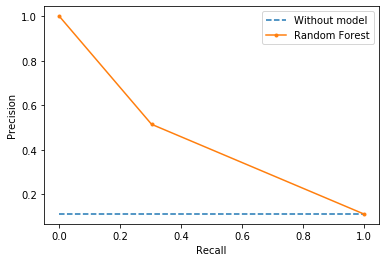

In [32]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_rf)
# plot the roc curve for the model
pos = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [pos,pos], linestyle='--', label='Without model')
pyplot.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [33]:
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.44828042176381466


We get comparable performance with Random forest and L1 regularized logistic regression